In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jahaj-1/Cruise-ships-1.png
/kaggle/input/testingset/221216150405-c919a.jpg


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy import ndimage
import math
import ast #to easily read out class text file that contains some unknwn syntax.
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2     
from keras.applications.resnet import ResNet50, preprocess_input
from keras.models import Model   
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the CIFAR10 DATASET <a class="anchor"  id="chapter1"></a>

In [3]:
(training_images, training_labels) , (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)


170498071/170498071 [==============================] - 3s 0us/step


## Tacher Network (ResNet50 with custom top)

In [4]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
 
  return feature_extractor



def classifier(inputs):
    x= tf.keras.layers.Conv2D(2048, (1, 1), strides=(1, 1), padding="same")(inputs)
    x= tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)  
    x = tf.keras.layers.Dense(10,name="classification")(x)
    return x



def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    
    
    classification_output = classifier(resnet_feature_extractor)

    return classification_output




def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


resnet50 = define_compile_model()

resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 2048)        4196352   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0      

In [5]:
resnet50.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


## Teacher Training

In [6]:
resnet50.fit(train_X, training_labels, epochs=3, validation_data = (test_X, test_labels), batch_size=64)

Epoch 1/3
782/782 [==============================] - 301s 350ms/step - loss: 0.3931 - accuracy: 0.8704 - val_loss: 0.2308 - val_accuracy: 0.9214
Epoch 2/3
782/782 [==============================] - 271s 346ms/step - loss: 0.1051 - accuracy: 0.9667 - val_loss: 0.2395 - val_accuracy: 0.9217
Epoch 3/3
782/782 [==============================] - 271s 346ms/step - loss: 0.0388 - accuracy: 0.9891 - val_loss: 0.1653 - val_accuracy: 0.9479


## Student Section

## Student Architecture

In [7]:
#proportionality maintained student
student_one = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Dense(10),
    ],
    name="student_one",
)

student_one.summary()

Model: "student_one"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                   

## Student training without KD

In [8]:
student_one.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


student_one.fit(train_X, training_labels, epochs=10)
student_one.evaluate(test_X, test_labels)


Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 1.8196 - sparse_categorical_accuracy: 0.3947
Epoch 2/10
 328/1563 [=====>........................] - ETA: 4s - loss: 1.4723 - sparse_categorical_accuracy: 0.4808

KeyboardInterrupt: 

## Student with baseline distillation

In [16]:
#proportionality maintained student
student_bl = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Dense(10),
    ],
    name="student_bl",
)

student_bl.summary()

Model: "student_bl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [18]:
class Distiller_bl(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
       
        x, y = data

  
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
           
            student_predictions = self.student(x, training=True)

            
            student_loss = self.student_loss_fn(y, student_predictions)

            
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

       
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        
        self.compiled_metrics.update_state(y, student_predictions)

       
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
       
        x, y = data

      
        y_prediction = self.student(x, training=False)

       
        student_loss = self.student_loss_fn(y, y_prediction)

      
        self.compiled_metrics.update_state(y, y_prediction)

       
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [19]:
distiller = Distiller_bl(student=student_bl, teacher=resnet50)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)


distiller.fit(train_X, training_labels, epochs=10)


distiller.evaluate(test_X, test_labels)

Epoch 1/10
1563/1563 [==============================] - 89s 54ms/step - sparse_categorical_accuracy: 0.4135 - student_loss: 2.2535 - distillation_loss: 9.6365
Epoch 2/10
1563/1563 [==============================] - 85s 54ms/step - sparse_categorical_accuracy: 0.5326 - student_loss: 1.7108 - distillation_loss: 7.4840
Epoch 3/10
1563/1563 [==============================] - 85s 54ms/step - sparse_categorical_accuracy: 0.5802 - student_loss: 1.5352 - distillation_loss: 6.7653
Epoch 4/10
1563/1563 [==============================] - 85s 54ms/step - sparse_categorical_accuracy: 0.6174 - student_loss: 1.3979 - distillation_loss: 6.2582
Epoch 5/10
1563/1563 [==============================] - 85s 54ms/step - sparse_categorical_accuracy: 0.6353 - student_loss: 1.3157 - distillation_loss: 5.9288
Epoch 6/10
1563/1563 [==============================] - 85s 54ms/step - sparse_categorical_accuracy: 0.6517 - student_loss: 1.2467 - distillation_loss: 5.6538
Epoch 7/10
1563/1563 [========================

[0.6754999756813049, 0.9314301013946533]

# Start of CAM experimentation

## Student Model

In [7]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, training_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [8]:
#proportionality maintained student
student_c1 = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Dense(10),
    ],
    name="student_c1",
)

student_c1.summary()

Model: "student_c1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

## CAM with mean absolute error with distillation loss

In [9]:
def plt_heatmap(img,heatmap,title):
    
    fig,ax= plt.subplots()
    ax.imshow(img)
    #ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.set_title(title) 
    plt.show()



def cam_loss(model_one,model_two,layer_one,layer_two,cam_img): 
    cifar10_classes = [
        
        'Airplane',
        'Automobile',
        'Bird',
        'Cat',
        'Deer',
        'Dog',
        'Frog',
        'Horse',
        'Ship',
        'Truck'
    ]
    
    img_tensor = np.expand_dims(cam_img, axis=0)
    preprocessed_img = preprocess_input(img_tensor)
    last_layer_weights = model_one.layers[-1].get_weights()[0]
    vis_model = Model(inputs=model_one.input, outputs=(model_one.layers[layer_one].output,model_one.layers[-1].output))
    with tf.GradientTape() as tape:
        last_conv_output, pred_vec = vis_model(preprocessed_img,training=False)
      
        last_conv_output = np.squeeze(last_conv_output) 
      
        pred = np.argmax(pred_vec)
   
    upsampled_last_conv_output = ndimage.zoom(last_conv_output, (4.57, 4.57, 1), order=1)
    last_layer_weights_for_pred = last_layer_weights[:, pred]
    heat_map = np.dot(upsampled_last_conv_output, last_layer_weights_for_pred) 
    flat=heat_map.flatten()
    
    #plt_heatmap(cam_img,heat_map,cifar10_classes[pred])
       
    
    last_layer_weights_2 = model_two.layers[-1].get_weights()[0]
    vis_model_2 = Model(inputs=model_two.input, outputs=(model_two.layers[layer_two].output,model_two.layers[-1].output))
    
    with tf.GradientTape() as tape:
        last_conv_output_2, pred_vec_2 = vis_model_2(preprocessed_img,training=False)
        last_conv_output_2 = np.squeeze(last_conv_output_2)         
        pred_2 = np.argmax(pred_vec_2)
        
    h = int(cam_img.shape[0]/last_conv_output_2.shape[0])
    w = int(cam_img.shape[1]/last_conv_output_2.shape[1])
    upsampled_last_conv_output_2 = ndimage.zoom(last_conv_output_2, (h, w, 1), order=1) 
    last_layer_weights_for_pred_2 = last_layer_weights_2[:, pred]
    heat_map_2 = np.dot(upsampled_last_conv_output_2, last_layer_weights_for_pred_2) 
    flat_2=heat_map_2.flatten()
    
        
    #plt_heatmap(cam_img,heat_map_2,cifar10_classes[pred_2])
    
    
    
    absolute_differences = np.abs(flat - flat_2)

    mae = np.mean(absolute_differences)
    
        
    
    return mae





class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.indexing=0

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
       
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        
    
    def train_step(self, x,y,conts):
       
       
        x_numpy=x.numpy()
       
             
        # retrieve the cam loss
        caml=(cam_loss(self.teacher,self.student,-4,-3,x_numpy[0]))
    
      
                                  
         
    
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
   
            student_predictions = self.student(x, training=True)

           
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
     
     
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss + caml
            
           
                            
        
        
        self.indexing=self.indexing+10
        if self.indexing>49500:
            self.indexing=0
       
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

       
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        
        self.compiled_metrics.update_state(y, student_predictions)

        
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
       
        return results,distillation_loss,caml

    def test_step(self, data):
     
        x, y = data

       
        y_prediction = self.student(x, training=False)

       
        student_loss = self.student_loss_fn(y, y_prediction)

      
        self.compiled_metrics.update_state(y, y_prediction)

       
        print('hi')
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [10]:
distiller_c1 = Distiller(student=student_c1, teacher=resnet50)
distiller_c1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

In [11]:
conts=1
epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
       
       

        history,l1,l2=distiller_c1.train_step(x_batch_train,y_batch_train,conts)
        conts+=1
    print(conts)
    tf.print(l1)
    print(l2)
    for key, value in history.items():
        print(key, tf.print(value))




Start of epoch 0
1564
6.80740356
17.907776
0.4014
accuracy None
1.51392436
student_loss None
6.80740356
distillation_loss None

Start of epoch 1
3127
8.86071682
17.736137
0.46048
accuracy None
2.09518743
student_loss None
8.86071682
distillation_loss None

Start of epoch 2
4690
5.17775536
11.11034
0.496006668
accuracy None
1.39571834
student_loss None
5.17775536
distillation_loss None

Start of epoch 3
6253
5.03438711
10.926349
0.522885
accuracy None
0.682399
student_loss None
5.03438711
distillation_loss None

Start of epoch 4
7816
5.34466314
10.147477
0.543232
accuracy None
1.69415045
student_loss None
5.34466314
distillation_loss None

Start of epoch 5
9379
3.69144583
15.350583
0.560056686
accuracy None
0.618289351
student_loss None
3.69144583
distillation_loss None

Start of epoch 6
10942
5.26822567
15.58484
0.574248552
accuracy None
1.49133635
student_loss None
5.26822567
distillation_loss None

Start of epoch 7
12505
3.48615074
20.043734
0.586062491
accuracy None
0.618195117
stu

In [12]:
distiller_c1.evaluate(test_X,test_labels)

hi
313/313 [==============================] - 1s 3ms/step - accuracy: 0.6825 - student_loss: 1.1912


[0.6825000047683716, 1.2466540336608887]

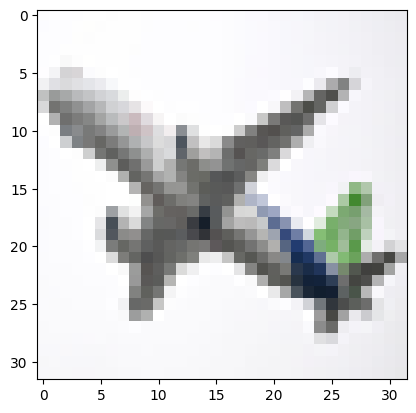

In [20]:
img = cv2.imread('/kaggle/input/testingset/221216150405-c919a.jpg', 1)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img, 'RGB')
img = img.resize((32, 32))
img = np.array(img)
plt.imshow(img)

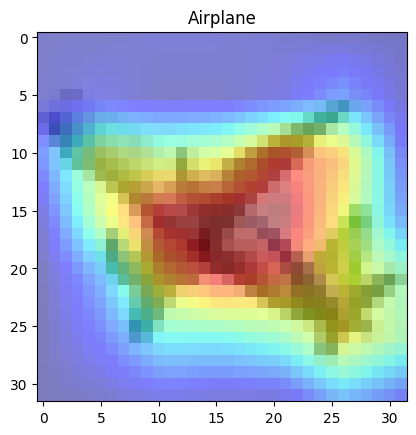

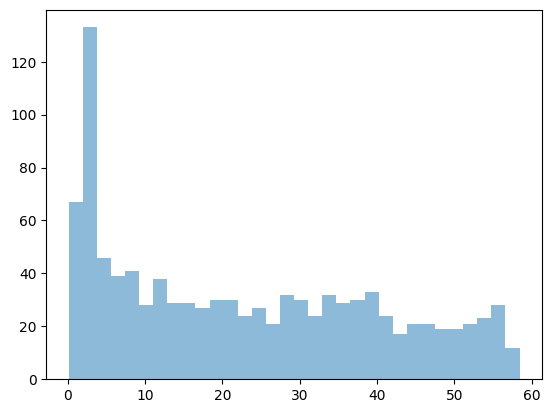

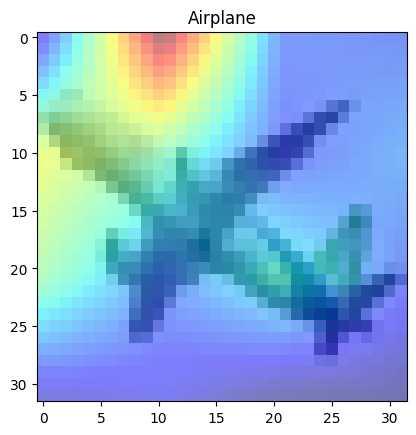

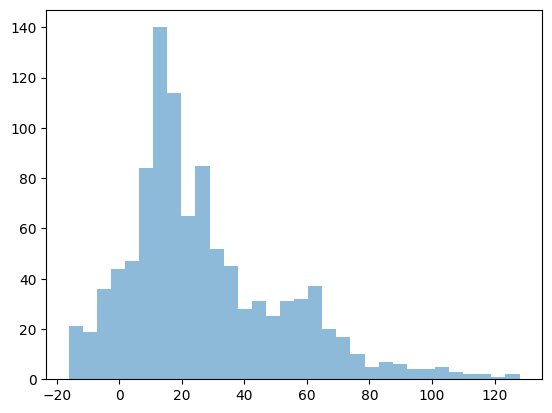

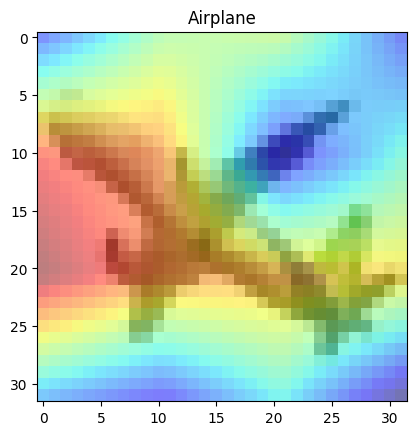

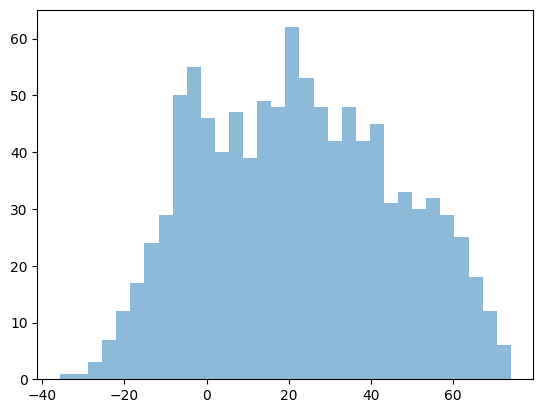

In [21]:
def plt_heatmap(img,heatmap,title):
    #Plot original image with heatmap overlaid. 
    fig,ax= plt.subplots()
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.set_title(title) 
    plt.show()
    
def plot_hist(heatmap):
    plt.hist(heatmap, bins=32, alpha=0.5, label='Histogram 1')
    plt.show()
    
def dist(data1,data2):
    absolute_differences = np.abs(data1 - data2)
    
    
    
    
    print(f'the mae: {absolute_differences}')
    


   



def cam_loss(model_one,model_two,model_three,layer_one,layer_two,cam_img): 
    cifar10_classes = [
        
        'Airplane',
        'Automobile',
        'Bird',
        'Cat',
        'Deer',
        'Dog',
        'Frog',
        'Horse',
        'Ship',
        'Truck'
    ]
    
    img_tensor = np.expand_dims(cam_img, axis=0)
    preprocessed_img = preprocess_input(img_tensor)
    last_layer_weights = model_one.layers[-1].get_weights()[0]
    vis_model = Model(inputs=model_one.input, outputs=(model_one.layers[layer_one].output,model_one.layers[-1].output))
    last_conv_output, pred_vec = vis_model.predict(preprocessed_img,verbose=0)
    #Last conv. output for the image
    last_conv_output = np.squeeze(last_conv_output) 
    #Prediction for the image
    pred = np.argmax(pred_vec)
   
    upsampled_last_conv_output = ndimage.zoom(last_conv_output, (4.57, 4.57, 1), order=1)
    last_layer_weights_for_pred = last_layer_weights[:, pred]
    heat_map = np.dot(upsampled_last_conv_output, last_layer_weights_for_pred) 
    flat=heat_map.flatten()
    
    plt_heatmap(cam_img,heat_map,cifar10_classes[pred])
    plot_hist(flat)
    
    

    
    
    
    last_layer_weights_2 = model_two.layers[-1].get_weights()[0]
    vis_model_2 = Model(inputs=model_two.input, outputs=(model_two.layers[layer_two].output,model_two.layers[-1].output))
    last_conv_output_2, pred_vec_2 = vis_model_2.predict(preprocessed_img,verbose=0)
    
    last_conv_output_2 = np.squeeze(last_conv_output_2) #7x7x2048
    
    pred_2 = np.argmax(pred_vec_2)
    h = int(cam_img.shape[0]/last_conv_output_2.shape[0])
    w = int(cam_img.shape[1]/last_conv_output_2.shape[1])
    upsampled_last_conv_output_2 = ndimage.zoom(last_conv_output_2, (h, w, 1), order=1) # dim: 224 x 224 x 2048
    last_layer_weights_for_pred_2 = last_layer_weights_2[:, pred]
    heat_map_2 = np.dot(upsampled_last_conv_output_2, last_layer_weights_for_pred_2) # dim: 224 x 224
    flat_2=heat_map_2.flatten()
    
    #print(heat_map_2[0])
    
    plt_heatmap(cam_img,heat_map_2,cifar10_classes[pred_2])
    plot_hist(flat_2)
    
    
    last_layer_weights_3 = model_three.layers[-1].get_weights()[0]
    vis_model_3 = Model(inputs=model_three.input, outputs=(model_three.layers[layer_two].output,model_three.layers[-1].output))
    last_conv_output_3, pred_vec_3 = vis_model_3.predict(preprocessed_img,verbose=0)
    
    last_conv_output_3 = np.squeeze(last_conv_output_3) #7x7x2048
    
    pred_3 = np.argmax(pred_vec_3)
    h = int(cam_img.shape[0]/last_conv_output_2.shape[0])
    w = int(cam_img.shape[1]/last_conv_output_2.shape[1])
    upsampled_last_conv_output_3 = ndimage.zoom(last_conv_output_3, (h, w, 1), order=1) # dim: 224 x 224 x 2048
    last_layer_weights_for_pred_3 = last_layer_weights_3[:, pred]
    heat_map_3 = np.dot(upsampled_last_conv_output_3, last_layer_weights_for_pred_3) # dim: 224 x 224
    flat_3=heat_map_3.flatten()
    
    #print(heat_map_2[0])
    
    plt_heatmap(cam_img,heat_map_3,cifar10_classes[pred_3])
    plot_hist(flat_3)
    



cam_loss(resnet50,student_bl,student_c1,-4,-3,img)
    

